In [1]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
pd.read_csv('kendall_11_w_id_n_blocks.csv')

,id,pos,chrom,K_tau,K_tau_p,MAF,block
0,1_346,346,1,0.150327,0.410134,0.232816,1_0
1,1_353,353,1,0.150327,0.410134,0.068148,1_0
2,1_363,363,1,-0.019608,0.940516,0.131263,1_0
3,1_395,395,1,-0.019608,0.940516,0.083211,1_0
4,1_396,396,1,-0.019608,0.940516,0.083211,1_0
...,...,...,...,...,...,...,...
1054569,5_26975078,26975078,5,-0.032680,0.881353,0.216872,5_3110
1054570,5_26975121,26975121,5,0.215686,0.229060,0.104103,5_3110
1054571,5_26975148,26975148,5,0.215686,0.229060,0.104103,5_3110
1054572,5_26975272,26975272,5,0.176471,0.329674,0.474413,5_3110


In [37]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/linages_wza_picmin/'

In [38]:
reps = [1000, 10000, 100000, 1000000]

In [67]:
reps = [10000000]

In [68]:
1e6

1000000.0

In [69]:
## create a dir 

# create sbatch files to submit on cedar server
shfiles = []
for rep in reps:
    seed = random.randint(1,100000000)
    file = f'picmin_run{rep}.sh'
    cmd = f'Rscript run_pic_min_deltap.r {rep}'
    text = f'''#!/bin/bash
#SBATCH --job-name=pic_min_run{rep}
#SBATCH --time=2-00:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=pic_min_run{rep}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
export PATH="${{PATH}}:/home/username/bin"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/linages_wza_picmin
conda activate /home/tbellagio/miniforge3/envs/r-environment
{cmd}

'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [70]:
shfiles

['picmin_run10000000.sh']

In [71]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 30376


In [10]:
picmin = pd.read_csv('picMin_results_deltap_1e+06rep.csv')
picmin['chrom'] = picmin['locus'].str.split('_').str[0].astype(int)
picmin['pos'] = picmin['locus'].str.split('_').str[1].astype(int)

In [13]:
picmin['n_est'].unique()

array([10, 12,  7,  2, 11,  6,  5,  8,  3,  4,  9])

In [16]:
picmin['n_est'].value_counts()

n_est
12    6417
11    2208
2     1910
3     1177
10    1137
4      820
9      655
5      593
8      530
6      529
7      482
Name: count, dtype: int64

In [4]:
biovar='bio1'

In [5]:
picmin = picmin.reset_index()

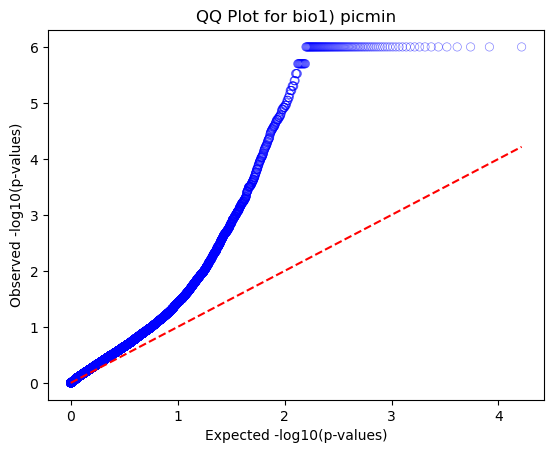

In [55]:
observed_quantiles = -np.log10(np.sort(picmin['p'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(picmin), 1, len(picmin)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) picmin')

plt.show()

In [56]:
0.05/len(picmin)

3.0380362133916637e-06

In [57]:
1/1000000

1e-06

In [58]:
picmin[picmin['p']<= 0.05/len(picmin)]

,index,numLin,p,q,n_est,locus,redundan,scaffold,start,chrom,pos
48,48,12,9.999990e-07,0.000158,2,1_1040,1,1040,NaN,1,1040
345,345,12,9.999990e-07,0.000158,4,1_1318,1,1318,NaN,1,1318
425,425,12,9.999990e-07,0.000158,3,1_1391,1,1391,NaN,1,1391
426,426,12,1.999998e-06,0.000265,5,1_1392,1,1392,NaN,1,1392
830,830,12,1.999998e-06,0.000265,2,1_1761,1,1761,NaN,1,1761
...,...,...,...,...,...,...,...,...,...,...,...
15992,15992,12,9.999990e-07,0.000158,5,5_562,5,562,NaN,5,562
16005,16005,12,9.999990e-07,0.000158,3,5_574,5,574,NaN,5,574
16087,16087,12,9.999990e-07,0.000158,3,5_649,5,649,NaN,5,649
16227,16227,12,9.999990e-07,0.000158,2,5_779,5,779,NaN,5,779


In [6]:
picmin['chrom'] = picmin['locus'].str.split('_').str[0].astype(int)
picmin['pos'] = picmin['locus'].str.split('_').str[1].astype(int)

In [7]:
#picmin = picmin[picmin['n_est']>6]

In [9]:
picmin['n_est'].unique()

array([10, 12,  7,  2, 11,  6,  5,  8,  3,  4,  9])

In [61]:
picmin.to_csv('linage_based_kendall_wza_picmin.csv',index=None)

In [62]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [63]:
# Load the 'rocket_r' colormap
original_cmap = cm.get_cmap('crest')

# Define a new colormap that ends less dark
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """
    Truncate a colormap by selecting a range of values.
    """
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        cmap.name + "_truncated",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a truncated version of 'rocket_r'
cmap = truncate_colormap(original_cmap, minval=0.0, maxval=0.7)

/tmp/ipykernel_1581898/304661063.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = cm.get_cmap('crest')


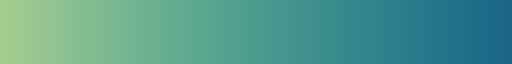

In [64]:
cmap

In [65]:
picminmost = picmin[picmin['n_est']>6]

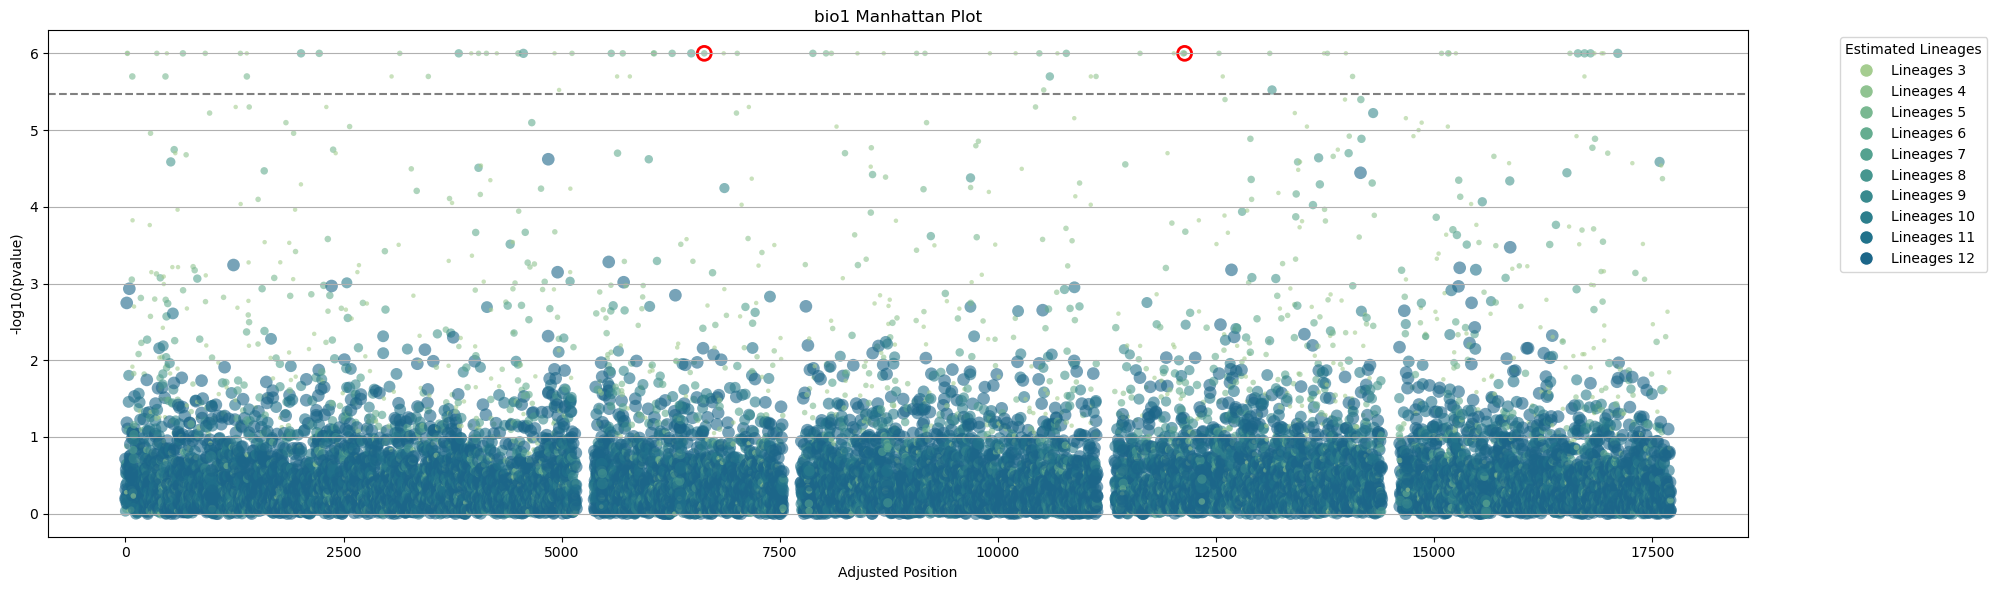

In [66]:
picminmost = picmin[picmin['n_est']>=3]
# Assuming picmin is a DataFrame already loaded with 'p', 'pos', 'n_est', 'chrom'
# picmin = pd.read_csv('path_to_your_data.csv')

threshold_value = 0.05 / len(picminmost)
biovar = 'bio1'

# Copy DataFrame and prepare data
df = picminmost[['p', 'pos', 'n_est', 'chrom']].copy()

# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 1.5  # Adjust this factor as needed
df['size'] = (df['n_est'] ** size_transform) *2

# Set up color map
n_est_unique = df['n_est'].unique()
norm = Normalize(vmin=min(n_est_unique), vmax=max(n_est_unique))


# Create a color map based on `n_est`
df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        c=subset['color'],  # Colors based on `n_est`
        s=subset['size'],  # Size based on `n_est`
        alpha=0.6,  # Transparency for better visibility
        label=f'Chr {chrom}',  # Label for the legend
        linewidth=0
    )
    
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}')
# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')  # Set the title
plt.grid(axis='y')

# Create a legend for the number of estimated lineages
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')

# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.show()

In [77]:
import pandas as pd
from collections import defaultdict

num_runs = 12
significant_gene_count = defaultdict(int)  # Dictionary to count significant occurrences of each gene

# Loop through each run and update the count of significant genes
for run in [1,3,5,6,7]:
    wza = pd.read_csv(f'../picmin/lin_{run}_pvalues.csv').reset_index()
    wza['name'] = wza['scaff'] + '_' + wza['start'].astype(int).astype(str)
    threshold_value = 0.01
    
    # Determine significant rows
    significant_rows = wza[wza['emp_p'] <= threshold_value]
    
    # Update the count of significant genes
    for gene in significant_rows['name']:
        significant_gene_count[gene] += 1

# Convert the results to a DataFrame for better readability
significant_gene_df = pd.DataFrame.from_dict(significant_gene_count, orient='index', columns=['sign_count'])
significant_gene_df.index.name = 'Gene'

In [78]:
wza

,index,outname,scaff,start,end,win_size,num_sites,num_snps,Rho,FstWC,dxy,AFD,FixedDiff,FstH,FstN,emp_p,name
0,0,ZEPSUB_WS1000_MS1,scaffold_5,23327000.0,23328000.0,1000,92,13,0.353457,0.238095,0.034901,0.027174,0,0.213625,0.151261,0.132882,scaffold_5_23327000
1,1,ZEPSUB_WS1000_MS1,scaffold_5,6000.0,7000.0,1000,560,19,0.344116,0.369527,0.004801,0.002328,0,0.372677,0.259890,0.037944,scaffold_5_6000
2,2,ZEPSUB_WS1000_MS1,scaffold_5,7000.0,8000.0,1000,309,21,0.316979,0.300890,0.006902,-0.000405,0,0.300611,0.207965,0.064381,scaffold_5_7000
3,3,ZEPSUB_WS1000_MS1,scaffold_5,14000.0,15000.0,1000,152,8,0.377625,0.429212,0.009303,0.003583,0,0.426451,0.301346,0.024570,scaffold_5_14000
4,4,ZEPSUB_WS1000_MS1,scaffold_5,15000.0,16000.0,1000,511,29,0.239130,0.164766,0.009769,0.005382,0,0.157016,0.117133,0.218957,scaffold_5_15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12856,12856,ZEPSUB_WS1000_MS1,scaffold_5,21215000.0,21216000.0,1000,769,11,0.189864,0.162250,0.002245,0.000731,0,0.177074,0.128991,0.183734,scaffold_5_21215000
12857,12857,ZEPSUB_WS1000_MS1,scaffold_5,21216000.0,21217000.0,1000,837,5,0.137324,0.113703,0.000915,-0.000075,0,0.134694,0.104225,0.269030,scaffold_5_21216000
12858,12858,ZEPSUB_WS1000_MS1,scaffold_5,21217000.0,21218000.0,1000,594,9,0.057692,0.035714,0.001263,0.000631,0,0.044444,0.054945,0.627440,scaffold_5_21217000
12859,12859,ZEPSUB_WS1000_MS1,scaffold_5,21218000.0,21219000.0,1000,845,19,0.082253,0.062194,0.003504,0.000666,0,0.083905,0.075940,0.436980,scaffold_5_21218000


In [80]:
significant_gene_df.sort_values('sign_count')

,sign_count
Gene,
scaffold_5_79000,1
scaffold_5_7582000,1
scaffold_5_7138000,1
scaffold_5_6920000,1
scaffold_5_6482000,1
...,...
scaffold_5_120000,3
scaffold_5_13415000,3
scaffold_5_9650000,3


In [53]:
lin1 = pd.read_csv('../picmin/lin_1_pvalues.csv')

In [58]:
th = 0.05/len(lin1)

In [67]:
th

3.739995512005386e-06

In [66]:
lin1[lin1['emp_p']< 0.01]

,outname,scaff,start,end,win_size,num_sites,num_snps,Rho,FstWC,dxy,AFD,FixedDiff,FstH,FstN,emp_p
43,BALTIS_WS1000_MS1,scaffold_5,79000.0,80000.0,1000,181,5,0.409336,0.508929,0.005525,0.005525,0,0.522177,0.367156,0.006283
44,BALTIS_WS1000_MS1,scaffold_5,80000.0,81000.0,1000,762,13,0.465001,0.692194,0.003978,0.003978,0,0.695710,0.544663,0.001421
48,BALTIS_WS1000_MS1,scaffold_5,84000.0,85000.0,1000,817,24,0.449560,0.533122,0.012548,-0.005929,0,0.533311,0.377611,0.005909
51,BALTIS_WS1000_MS1,scaffold_5,87000.0,88000.0,1000,302,18,0.433058,0.475817,0.019181,-0.010821,0,0.482019,0.332120,0.008527
79,BALTIS_WS1000_MS1,scaffold_5,115000.0,116000.0,1000,423,14,0.464540,0.615356,0.014295,-0.009382,0,0.615070,0.456770,0.002917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,BALTIS_WS1000_MS1,scaffold_5,19701000.0,19702000.0,1000,241,22,0.424171,0.466827,0.037477,-0.017802,0,0.470003,0.322529,0.009425
12658,BALTIS_WS1000_MS1,scaffold_5,20383000.0,20384000.0,1000,95,5,0.422353,0.480010,0.025806,-0.014239,0,0.483990,0.335338,0.008303
12967,BALTIS_WS1000_MS1,scaffold_5,20767000.0,20768000.0,1000,313,4,0.457952,0.613839,0.006390,0.005990,0,0.615927,0.457651,0.002842
13010,BALTIS_WS1000_MS1,scaffold_5,20835000.0,20836000.0,1000,25,1,0.464061,0.741095,0.031250,-0.031250,0,0.774194,0.641026,0.000598


In [57]:
lin1.sort_values('emp_p')

,outname,scaff,start,end,win_size,num_sites,num_snps,Rho,FstWC,dxy,AFD,FixedDiff,FstH,FstN,emp_p
84,BALTIS_WS1000_MS1,scaffold_5,120000.0,121000.0,1000,108,5,0.493193,0.930823,0.019841,0.019841,2,0.934568,0.881299,0.000075
87,BALTIS_WS1000_MS1,scaffold_5,123000.0,124000.0,1000,173,11,0.496059,0.930489,0.043740,-0.025263,1,0.931399,0.875588,0.000150
10167,BALTIS_WS1000_MS1,scaffold_5,17443000.0,17444000.0,1000,406,15,0.474371,0.837194,0.015654,0.009629,0,0.842716,0.736903,0.000224
2453,BALTIS_WS1000_MS1,scaffold_5,3865000.0,3866000.0,1000,190,10,0.455011,0.807792,0.033772,-0.008333,0,0.827216,0.715877,0.000299
1212,BALTIS_WS1000_MS1,scaffold_5,2107000.0,2108000.0,1000,146,5,0.476480,0.819867,0.016756,-0.016756,0,0.817119,0.701507,0.000374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,BALTIS_WS1000_MS1,scaffold_5,3095000.0,3096000.0,1000,21,1,-0.237624,-0.104348,0.022817,-0.001984,0,-0.039698,0.001815,0.999701
4826,BALTIS_WS1000_MS1,scaffold_5,10312000.0,10313000.0,1000,8,1,-0.220290,-0.039715,0.009301,-0.000744,0,-0.040000,0.000238,0.999850
2604,BALTIS_WS1000_MS1,scaffold_5,4074000.0,4075000.0,1000,30,1,-0.220290,-0.039715,0.002480,0.000198,0,-0.040000,0.000238,0.999850
3262,BALTIS_WS1000_MS1,scaffold_5,5076000.0,5077000.0,1000,5,1,-0.220290,-0.039715,0.014881,-0.001190,0,-0.040000,0.000238,0.999850


<Axes: xlabel='emp_p', ylabel='Count'>

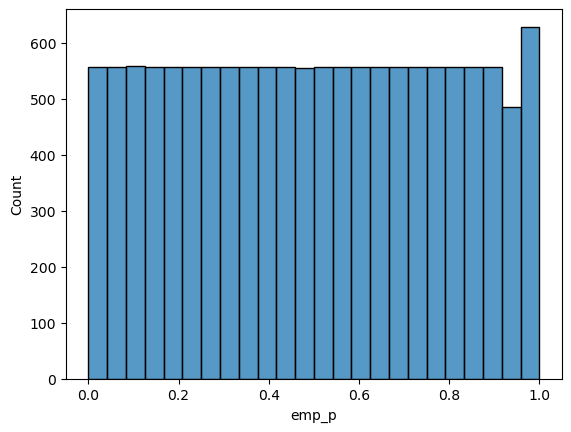

In [51]:
sns.histplot(pd.read_csv('../picmin/lin_1_pvalues.csv')['emp_p'])

<Axes: xlabel='emp_p', ylabel='Count'>

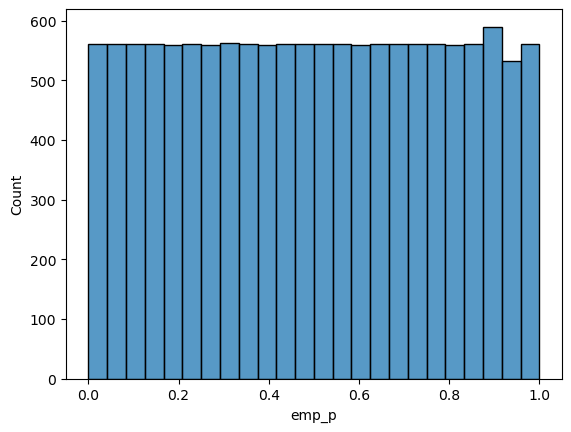

In [52]:
sns.histplot(pd.read_csv('../picmin/lin_3_pvalues.csv')['emp_p'])

In [62]:
wza1 = pd.read_csv('wza_run1_results.csv')

<Axes: xlabel='Z_pVal', ylabel='Count'>

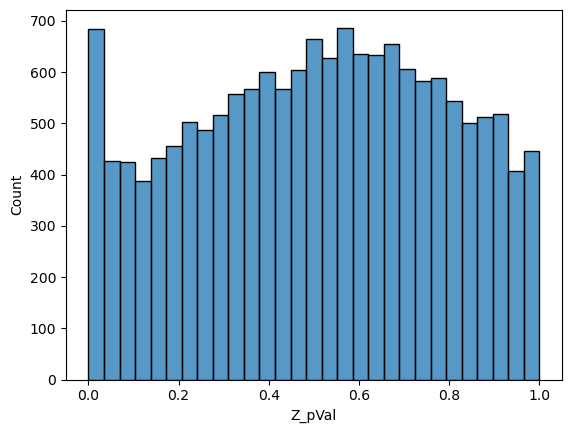

In [64]:
sns.histplot(wza1['Z_pVal'])

In [ ]:
wza_run", run, "_results.csv")